In [31]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=''
import tensorflow as tf
import numpy as np
import numpy.random as rng
from data_loader.data_generator import MNISTDataGenerator, LinearDataGenerator
from models.npmodels import NPModel4,DirectNPModel4,AENPModel,AEDFANPModel
from trainers.sf_trainer import SFTrainer, AESFTrainer
from utils.config import process_config
import shutil
import numpy as np
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go

import pickle
import itertools
from utils.utils import tf_matmul_r, tf_matmul_l, tf_eigvecs, tf_eigvals


In [2]:
inshape=30
hidden=20
outshape=10
batch_size=50
T = rng.randn(outshape, inshape)
def traindata(T, batch_size):
    train_x = rng.randn( batch_size,T.shape[1])
    train_y = np.dot( train_x,T.T)
    return (train_x, train_y)

In [3]:
#p = self.config.state_size[0]
p=30# inshape 
m =20# hiddenshap
j = 10#outshpae
#n = 10
var_xi = 0.1
# learning_rate=0
# lmda_learning_rate=1e-5
#lmda_learning_rate=0

#Training data inputs
x=tf.placeholder(tf.float32,[None,p], name = 'x')
y=tf.placeholder(tf.float32,[None,j], name = 'y')
learning_rate=tf.placeholder(tf.float32,[None],name='learning_rate')
lmda_learning_rate=tf.placeholder(tf.float32,[None],name='lmda_learning_rate')

#Scale weight initialization
alpha0 = np.sqrt(2.0/p)
alpha1 = np.sqrt(2.0/m)
alpha2 = np.sqrt(2.0/j)
alpha3 = 1

A = tf.Variable(rng.randn(p+1,m)*alpha0, name="hidden_weights", dtype=tf.float32)
W = tf.Variable(rng.randn(m+1,j)*alpha1, name="output_weights", dtype=tf.float32)
B = tf.Variable(rng.randn(m+1,j)*alpha2, name="feedback_weights", dtype=tf.float32)

# network architecture with ones added for bias terms
e0 = tf.ones([batch_size, 1], tf.float32)
e1 = tf.ones([batch_size, 1], tf.float32)
x_aug = tf.concat([x, e0], 1)
h = tf.sigmoid(tf.matmul(x_aug, A))
#Make some noise
h_aug = tf.concat([h, e1], 1)
xi = tf.random_normal(shape=tf.shape(h_aug), mean=0.0, stddev=var_xi, dtype=tf.float32)
h_tilde = h_aug + xi
#Add noise to hidden layer
y_p = tf.matmul(h_tilde, W)
y_p_0 = tf.matmul(h_aug, W)

trainable = [A, W, B]


In [4]:
#mean squared error
loss = tf.reduce_sum(tf.pow(y_p-y, 2))/2
loss_0 = tf.reduce_sum(tf.pow(y_p_0-y, 2))/2
e = (y_p - y)
h_prime = tf.multiply(h_tilde, 1-h_tilde)[:,0:m]

#Feedback data for saving
#Only take first item in epoch
delta_bp = tf.matmul(e, tf.transpose(W[0:m,:]))[0,:]
delta_fa = tf.matmul(e, tf.transpose(B[0:m,:]))[0,:]
norm_W = tf.norm(W)
norm_B = tf.norm(B)
error_FA = tf.norm(delta_bp - delta_fa)
alignment = tf.reduce_sum(tf.multiply(delta_fa,delta_bp))/tf.norm(delta_fa)/tf.norm(delta_bp)
norm_diff = tf.norm(W - B)
eigs = tf_eigvals(tf.matmul(tf.transpose(B), W))

#Compute updates for W and A (based on B)
lmda = tf.matmul(e, tf.transpose(B[0:m,:]))
grad_W = tf.gradients(xs=W, ys=loss)[0]
grad_A = tf.matmul(tf.transpose(x_aug), tf.multiply(h_prime, lmda))
grad_B = tf.matmul(tf.matmul(B, tf.transpose(e)) - tf.transpose(xi)*(loss - loss_0)/var_xi, e)

new_W = W.assign(W - learning_rate*grad_W)
new_A = A.assign(A - learning_rate*grad_A)            
new_B = B.assign(B - lmda_learning_rate*grad_B)
train_step = [new_W, new_A, new_B]


# correct_prediction = tf.equal(tf.argmax(y_p, 1), tf.argmax(y, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# #Also need to add eigenvector stuff
# training_metrics = [alignment, norm_W, norm_B, error_FA, eigs[0]]

In [5]:
init = tf.global_variables_initializer()

eta_1=np.logspace(-3,-6,10)
# eta_1=[0.1,0.1,0.1,0.1,0.1,0.1]
eta_lmda=np.logspace(-3,-6,10)
combo=list(itertools.product(eta_1[::-1],eta_lmda[::-1]))
iteration=2000
store_al=np.zeros([len(combo),iteration])
store_df=np.zeros([len(combo),iteration])
# store_err=[[] for i in range(len(combo))]
store_err=np.zeros([len(combo),iteration])
non_converge=[]
with tf.Session() as sess:
    for i in range(len(combo)):
        sess.run(init)
        print("Present combo:",i+1)
        print("Present learning rate:",combo[i][0])
        learning_rate1=[combo[i][0]]
        lmda_learning_rate1=[combo[i][1]]
        print("Present lmda learning rate:",combo[i][1])  
        flag=0
        for idx in range(iteration):
            (train_x, train_y) = traindata(T, batch_size) 
            _,align,diff,err=sess.run([train_step,alignment,norm_diff,loss_0],feed_dict={x: train_x, y: train_y,
                                                                                        learning_rate:learning_rate1,
                                                                                         lmda_learning_rate:lmda_learning_rate1})
            if flag==0:
                if np.isnan(err)==True:
                    print("\n\tModel does not converge!!!\n")
                    non_converge.append(i)
                    flag=1
                    break
                    
            store_al[i,idx]=align
            store_df[i,idx]=diff
#             store_err[i].append(err)
            store_err[i,idx]=err
#             if (idx+1)%500==0:
#                 print("Iteration count:",idx+1)

# for rem in non_converge:
#     del store_err[rem]    

Present combo: 1
Present learning rate: 1e-06
Present lmda learning rate: 1e-06
Present combo: 2
Present learning rate: 1e-06
Present lmda learning rate: 2.1544346900318865e-06
Present combo: 3
Present learning rate: 1e-06
Present lmda learning rate: 4.641588833612782e-06
Present combo: 4
Present learning rate: 1e-06
Present lmda learning rate: 1e-05
Present combo: 5
Present learning rate: 1e-06
Present lmda learning rate: 2.1544346900318867e-05
Present combo: 6
Present learning rate: 1e-06
Present lmda learning rate: 4.641588833612782e-05
Present combo: 7
Present learning rate: 1e-06
Present lmda learning rate: 0.0001
Present combo: 8
Present learning rate: 1e-06
Present lmda learning rate: 0.00021544346900318845
Present combo: 9
Present learning rate: 1e-06
Present lmda learning rate: 0.00046415888336127773
Present combo: 10
Present learning rate: 1e-06
Present lmda learning rate: 0.001

	Model does not converge!!!

Present combo: 11
Present learning rate: 2.1544346900318865e-06
Pres

Present combo: 80
Present learning rate: 0.00021544346900318845
Present lmda learning rate: 0.001

	Model does not converge!!!

Present combo: 81
Present learning rate: 0.00046415888336127773
Present lmda learning rate: 1e-06
Present combo: 82
Present learning rate: 0.00046415888336127773
Present lmda learning rate: 2.1544346900318865e-06
Present combo: 83
Present learning rate: 0.00046415888336127773
Present lmda learning rate: 4.641588833612782e-06
Present combo: 84
Present learning rate: 0.00046415888336127773
Present lmda learning rate: 1e-05
Present combo: 85
Present learning rate: 0.00046415888336127773
Present lmda learning rate: 2.1544346900318867e-05
Present combo: 86
Present learning rate: 0.00046415888336127773
Present lmda learning rate: 4.641588833612782e-05
Present combo: 87
Present learning rate: 0.00046415888336127773
Present lmda learning rate: 0.0001
Present combo: 88
Present learning rate: 0.00046415888336127773
Present lmda learning rate: 0.00021544346900318845
Pres

In [6]:
store_err_s=[]
store_al_s=[]
store_df_s=[]
print("Following indexes did not converge",non_converge)
for count in range(store_err.shape[0]):
    if count in non_converge:
        print("removing row:",count)
    else:
        store_err_s.append(store_err[count,:]) 
#         store_al_s.append(store_al[count,:])


store_err_s=np.array(store_err_s)

for val in sorted(non_converge,reverse=True):
    del combo[val]
eta_1new=[]
eta_lmdanew=[]
for first,second in combo:
    if first not in eta_1new:
        eta_1new.append(first)
    if second not in eta_lmdanew:
        eta_lmdanew.append(second)
eta_1new=np.array(eta_1new)
eta_lmdanew=np.array(eta_lmdanew)

Following indexes did not converge [9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
removing row: 9
removing row: 19
removing row: 29
removing row: 39
removing row: 49
removing row: 59
removing row: 69
removing row: 79
removing row: 89
removing row: 99


In [7]:
#storing last values for error and reshaping into appropriate format
last_val=np.zeros([eta_1new.shape[0]*eta_lmdanew.shape[0],1])
for num in range(store_err_s.shape[0]):
    last_val[num]=store_err_s[num][-1]
reshape_err=np.reshape(last_val,[eta_1new.shape[0],eta_lmdanew.shape[0]])

In [8]:
# combo=list(itertools.product(eta_1[::-1],eta_lmda[::-1]))
# combo


In [9]:
lf_df=np.zeros([eta_1.shape[0]*eta_lmda.shape[0],10]) #stores last 10 norm_dfs
mean_df=np.zeros([eta_1.shape[0]*eta_lmda.shape[0],1]) #stores mean of last 10 norm_dfs
for num in range(store_df.shape[0]):
    lf_df[num,:]=store_df[num,iteration-10:iteration]
    mean_df[num]=np.mean(store_df[num,iteration-10:iteration])
    
reshape_df=np.reshape(mean_df,[eta_1.shape[0],eta_lmda.shape[0]])

In [10]:
last_al=np.zeros([eta_1.shape[0]*eta_lmda.shape[0],1])
for num2 in range(store_al.shape[0]):
    last_al[num2]=store_al[num2][-1]

reshape_al=np.reshape(last_al,[eta_1.shape[0],eta_lmda.shape[0]])


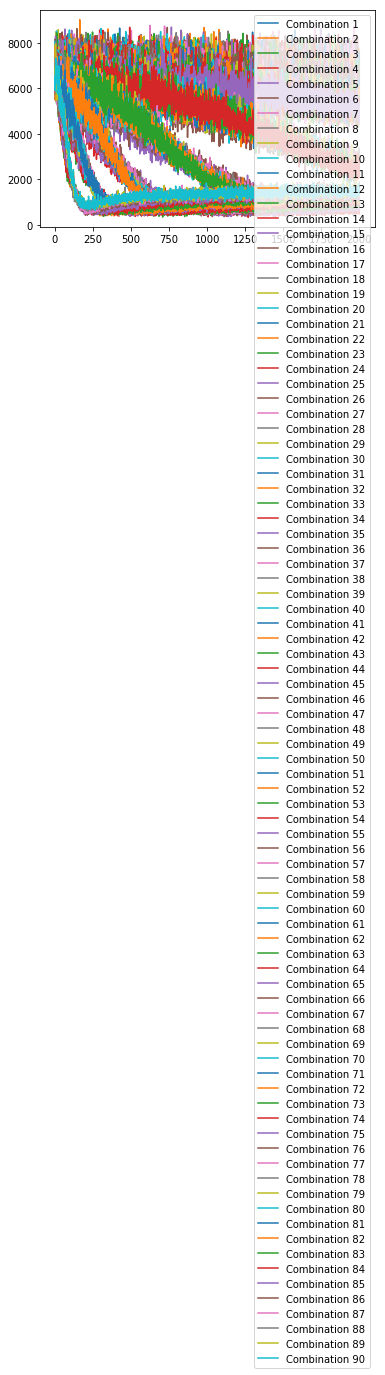

In [11]:
# x=[i for i in range(iteration)]
for i in range(len(store_err_s)):
    leg='Combination '+str(i+1)
    plt.plot(store_err_s[i,:],label=leg)
plt.legend()
plt.show()

In [12]:
eta_xtick=eta_1new
for x in range(len(eta_1new)):
    eta_xtick[x]="%0.1e" % eta_1new[x]
eta_ytick=eta_lmdanew
for y in range(len(eta_lmdanew)):
    eta_ytick[y]="%0.1e" % eta_lmdanew[y]

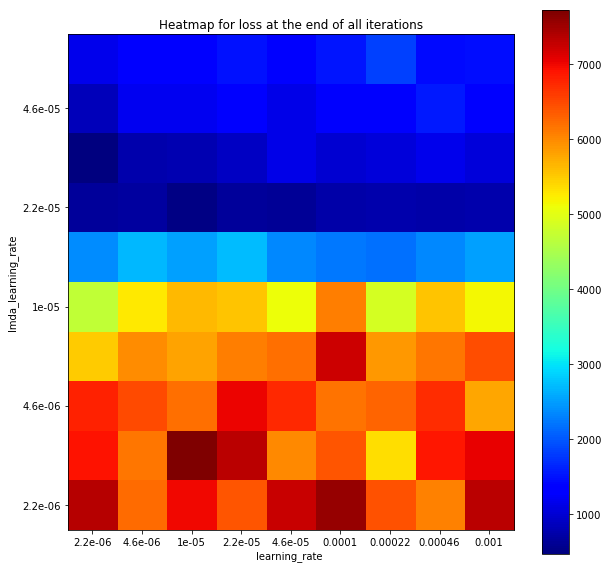

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# plt.axes(xscale='log',yscale='log')
# ax.locator_params(axis='y',nbins=len(eta_ytick))
# ax.locator_params(axis='x',nbins=len(eta_xtick))
h=ax.imshow(reshape_err, origin='lower',cmap='jet',interpolation='none')
plt.colorbar(h,ax=ax)

# .MaxNLocator(3)
ax.set_xticklabels([str(eta) for eta in eta_xtick])
ax.set_yticklabels([str(eta) for eta in eta_ytick])


# ax.set_xticks(strings)
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 0.712123))
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.01e'))




# ax.set_ticks(eta_xtick)

ax.set_xlabel("learning_rate ")
ax.set_ylabel("lmda_learning_rate")
plt.title("Heatmap for loss at the end of all iterations")
plt.show()

In [14]:
eta_xtick

array([1.0e-06, 2.2e-06, 4.6e-06, 1.0e-05, 2.2e-05, 4.6e-05, 1.0e-04,
       2.2e-04, 4.6e-04, 1.0e-03])

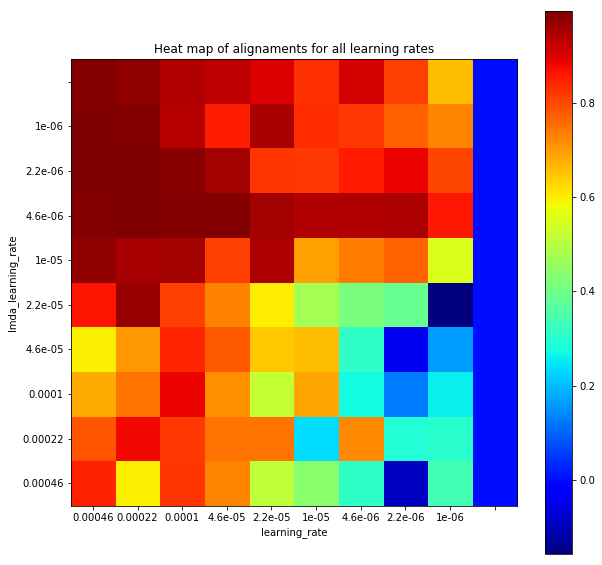

In [29]:
eta_xtick1=eta_1
for x in range(len(eta_1)):
    eta_xtick1[x]="%0.1e" % eta_1[x]
eta_ytick1=eta_lmda
for y in range(len(eta_lmda)):
    eta_ytick1[y]="%0.1e" % eta_lmda[y]
    
    
fig,ax=plt.subplots(1,1,figsize=(10,10))

h2=plt.imshow(reshape_al,cmap='jet',origin='lower')
plt.colorbar(h2,ax=ax)
ax.locator_params(axis='x',nbins=len(eta_xtick1))
ax.locator_params(axis='y',nbins=len(eta_ytick1))
ax.set_xticklabels([str(eta) for eta in eta_xtick1])
ax.set_yticklabels([str(eta) for eta in eta_ytick1])


plt.title("Heat map of alignaments for all learning rates")
ax.set_xlabel("learning_rate")
ax.set_ylabel("lmda_learning_rate")
plt.show()

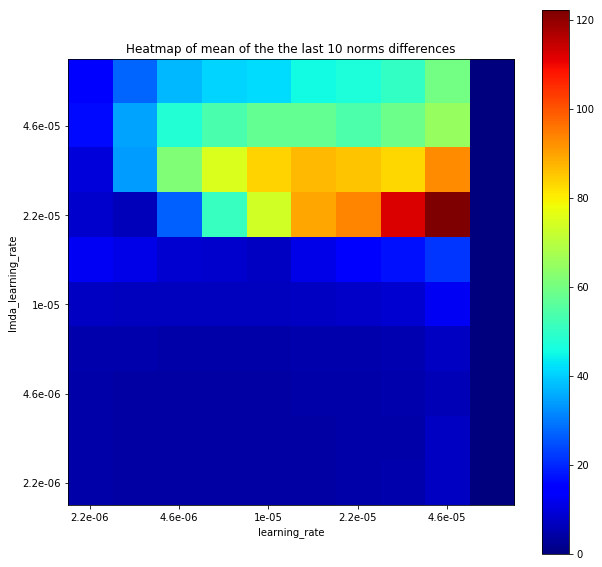

In [32]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
h3=plt.imshow(reshape_df,cmap='jet',origin='lower')
plt.colorbar(h3,ax=ax)

ax.set_xticklabels([str(eta) for eta in eta_xtick])
ax.set_yticklabels([str(eta) for eta in eta_ytick])

plt.title("Heatmap of mean of the the last 10 norms differences")
plt.xlabel("learning_rate")
plt.ylabel("lmda_learning_rate")
plt.show()

# for iter in range(lf_df.shape[0]):
#     leg='Combination '+str(iter+1)
#     plt.plot(lf_df[iter,:],label=leg)
# plt.title("Last 10 norm fifferences for every combination of learnig rates")
# plt.legend()
# plt.show()           
    
# # fig, ax1 = plt.subplots(1,1)
# # data = np.random.randint(0, 100, size=(10, 10))
# # ax1.imshow(data, cmap='jet', interpolation='nearest')
# # ax1.set_xticklabels(['', 0,10,20,30,40])
# # plt.show()

In [16]:
strings = ["%.01e" % number for number in eta_1new]
eta_1new
strings

['1.0e-06',
 '2.2e-06',
 '4.6e-06',
 '1.0e-05',
 '2.2e-05',
 '4.6e-05',
 '1.0e-04',
 '2.2e-04',
 '4.6e-04',
 '1.0e-03']

In [17]:
print(len(xlabels))
print(eta_1new.shape[0])
print(reshape_err.shape)

NameError: name 'xlabels' is not defined

In [ ]:
# # store_err_a=np.array(store_err)
# # len(store_err)
# np.where(np.isnan(store_err)==True)
# plt.imshow(store_err,cmap='hot',interpolation='nearest',aspect='auto')
# plt.show()

In [ ]:
# heatmap = plt.pcolor(store_err)
# plt.show()

In [ ]:
str(eta_1new)